# Redes Neurais para Previsão de Trajetória

Neste notebook, usaremos redes neurais para previsão de trajetória futura de uma tempestade. A ideia geral é dado as informações de um furacão de algumas horas atrás e do presente, projetaremos a sua posição futura. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
from sklearn.metrics import r2_score
%matplotlib inline

In [2]:
import tensorflow as tf

tf.keras.backend.clear_session()  

print(tf.__version__)

2.0.0


## Preparação dos dados

Iremos abaixo criar funções para preparar nossos dados para o modelo, e aplicá-las ao dataframe original

In [3]:
#Leitura dos dados
data = pd.read_csv('../Datasets/data_atl_merged2.csv',parse_dates=['Date'])
data.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Year',
       'Month', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'sst', 'rhum',
       'wspd', 'slp', 'cldc'],
      dtype='object')

In [4]:
## Funções de Padronização e Normalização:
def min_max_scale(data,cols):
    df = data.copy()
    for col in cols:
        min_ = df[col].min()
        max_ = df[col].max()
        df.loc[:,col] = (df[col]-min_)/(max_-min_)
    return df[cols]
def mim_max_scale_back(scaled,original,cols):
    df = scaled.copy()
    for col in cols:
        min_ = original[col].min()
        max_ = original[col].max()
        df.loc[:,col] = df[col]*(max_-min_)+min_
    return df[cols]
def standard_scale(data,cols):
    df = data.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[:,col] = (df[col]-mean)/std
    return df[cols]
def standard_scale_back(scaled,original,cols):
    df = scaled.copy()
    for col in cols:
        mean = original[col].mean()
        std = original[col].std()
        df.loc[:,col] = df[col]*std+mean
    return df[cols]

In [5]:
# Função que divide os dados por ID da tempestade
def split(df):
    st = []
    ids = df.ID.unique()
    for ID in ids:
        st.append(df[df.ID==ID])
    return st
splitted = split(data)
print(len(splitted))

685


A função "clean_data" formata o preditor Tempo, o convertendo para horas (por padrão, horas após Jan/1951), e padroniza os dados de input.

A função "shift_data", faz um shift dos dados e dá como saída as matriz tridimensional X e o vetor Y, onde X é composto por matrizes $s\times n$:

$$\left[\begin{matrix}
x_1^{(t-s+1)} & x_2^{(t-s+1)} & ...& x_n^{(t-s+1)}\\
x_1^{(t-s+2)} & x_2^{(t-s+2)} & ...& x_n^{(t-s+2)}\\
\vdots &\vdots &\vdots &\vdots\\
x_1^{(t)} & x_2^{(t)} & ...& x_n^{(t)}\end{matrix}\right]$$

na qual:

- $x_1,~x_2, ~..., ~x_n$ representam os $n$ preditores usados (Usaremos 4 inicialmente: tempo latitude, longitude e velocidade de vento)

- $x_i^{(k)}$ representa o preditor $i$ no registro de tempo $k$. 

- $s$ é o parâmetros "shift", que representa em quantos períodos passados basearemos a previsão futura. Por padrão, inicialmente, deixamos $s=3$. Como cada registro é espaçado por 6 horas, neste formado estamos usando daados do presente e de 12 horas atrás, pra projetar o dado futuro.

Sendo assim, trabalhando com $s=3$ temos que as matrizes de X serão do tipo:

$$\left[\begin{matrix}
x_1^{(t-2)} & x_2^{(t-2)} & ...& x_n^{(t-2)}\\
x_1^{(t-1)} & x_2^{(t-1)} & ...& x_n^{(t-1)}\\
x_1^{(t)} & x_2^{(t)} & ...& x_n^{(t)}\end{matrix}\right]$$


O vetor $Y$ geral é composto por:

$$\left[\begin{matrix}lat^{(t+1)}&lon^{(t+1)}\\
lat^{(t+2)}&lon^{(t+2)}\\
\vdots & \vdots\\
lat^{(t+p)}&lon^{(t+p)}\end{matrix}\right]$$

na qual:

- $lat^{(k)}$ e $lon^{(k)}$ representam latitude e longitude no registro de tempo $k$
- $p$ é o parâmetro "pred", que diz quantos períodos à frente iremos prever. Por padrão, deixamos $p=1$, assim a matriz se resume em um vetor $[lat^{(t+1)},~ lon^{(t+1)}]$. Usamos previsões de 3 registros passados para prever o próximo registro após o último ponto de treino. Um trabalho futuro seria usar intervalos de previsões maiores, mas vamos nos ater aqui a apenas 1 registro à frete, o que equivale a 6 horas na grande maiorias dos pontos.



In [6]:
cols1 = ['Hours','Latitude','Longitude','Maximum Wind']
data.loc[:,'Time_new']=data.Date+data.Time.map(lambda x: pd.Timedelta(hours=x/100))

def clean_data(df,input_cols = cols1, year0 = 1951):
    df2 = df.copy()
    df2.loc[:,'Hours'] = (df2.loc[:,'Time_new']-pd.Timestamp(year0,1,1))/pd.Timedelta('1 hour')
    df2.loc[:,input_cols] = standard_scale(df2,input_cols)
    return df2[['ID']+input_cols]

def shift_data(df,shift = 3,pred = 1):

    x = []
    y = []
    df = df.set_index(np.arange(0,len(df)))
    for i in range(0,len(df)-shift):
        x_arr = []
        for j in range(i,i+shift):
            x_arr.append(df.loc[j,:])
        if pred == 1:
            y.append(np.array(df.loc[i+shift:i+shift+pred-1,['Latitude','Longitude']]).ravel())
        else:
            y.append(np.array(df.loc[i+shift:i+shift+pred-1,['Latitude','Longitude']]))
        x.append(np.array(x_arr))
       
    return np.array(x),np.array(y)

In [7]:
data_cleaned = clean_data(data)
data_cleaned.describe()

,Hours,Latitude,Longitude,Maximum Wind
count,2.238600e+04,2.238600e+04,2.238600e+04,2.238600e+04
mean,-1.312271e-17,3.398752e-15,4.449279e-15,5.249630e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.823465e+00,-1.939104e+00,-2.303286e+00,-1.644750e+00
25%,-8.725997e-01,-8.005268e-01,-7.741070e-01,-8.529203e-01
50%,1.595638e-01,-4.466462e-02,-5.884587e-02,-2.590479e-01
75%,9.229854e-01,6.250867e-01,7.057436e-01,5.327820e-01
max,1.499554e+00,5.121988e+00,6.195990e+00,4.491932e+00


### Treino, Validação e Teste

Para formatar os dados de treino, teste e validação, primeiramente, usamos a função "split", que separa os dados em uma lista de dataframes onde cada um deles representa uma tempestade diferente.

Após isso atribuimos 70% da lista para treino, 20% para validação e 10% para teste. Cada dataframe é devidamente formatado para as matrizes acima usando a função "shift_data", e após isso, unimos as matrizes de saída para gerar a numpy array final, do modelo.

Se fizéssemos o split diretamente, esse tipo de erro poderia acontecer. Suponha que uma tempestade tem seu último registro em 20 de Agosto em um determinado local, e uma outra tempestade se inicial dia 21 de Agosto em um local totalmente diferente. Um split direto poderia usar o registro de 20 de Agosto para prever o do dia 21, sendo que não há relação entre eles.

Essa separação por tempestade é importante para garantir a integridade dos nossos dados de modelagem, de forma que o treinamento seja feito tempestade por tempestade.

In [8]:
def train_val_test_split(df,t=0.7,v=0.2,input_cols=cols1,shift=3,pred=1):
    # t = fração de treino
    # v = fração de validação
    # fração de teste = 1-t-v
    # df = dataset já limpo por clean_data
    splitted_data = split(df)
    # Separamos os dados tempestade por tempestade para 
    # evitar cruzamento de dados entre eventos diferentes
    n = len(splitted_data)
    
    train_storms = splitted_data[0:int(n*t)]
    val_storms = splitted_data[int(n*t):int(n*(t+v))]
    test_storms = splitted_data[int(n*(1-t-v)):]
    
    #Geramos uma lista de matrizes, onde cada lista se refere 
    #aos dados descocados de uma tempestade diferente
    xy_train = [shift_data(train[input_cols],shift,pred) for train in train_storms]
    xy_val = [shift_data(val[input_cols],shift,pred) for val in val_storms]
    xy_test = [shift_data(test[input_cols],shift,pred) for test in test_storms]
    
    # Concatenação das matrizes para gerar os dados finais
    xtrain = np.concatenate([x[0] for x in xy_train],axis=0)
    ytrain = np.concatenate([y[1] for y in xy_train],axis=0)

    xval = np.concatenate([x[0] for x in xy_val],axis=0)
    yval = np.concatenate([y[1] for y in xy_val],axis=0)

    xtest = np.concatenate([x[0] for x in xy_test],axis=0)
    ytest = np.concatenate([y[1] for y in xy_test],axis=0)
    
    return xtrain, ytrain, xval, yval, xtest, ytest

In [9]:
%%time
#O processo de split pode ser lento à depender de seu computador
xtrain, ytrain, xval, yval, xtest, ytest = train_val_test_split(data_cleaned)

xtrain.shape,ytrain.shape,xval.shape,yval.shape,xtest.shape,ytest.shape

CPU times: user 57.7 s, sys: 48.5 ms, total: 57.8 s
Wall time: 57.7 s


((14010, 3, 4), (14010, 2), (4401, 3, 4), (4401, 2), (18482, 3, 4), (18482, 2))

In [10]:
%%time
## Modelo que usa sst, rhum, slp e cldc (Temperatura do mar, Umidade, Pressão e Nebulosidade)
cols2 = cols1 + ['sst','rhum','slp','cldc']
cleaned2 = clean_data(data,cols2)

xtrain2, ytrain2, xval2, yval2, xtest2, ytest2 = train_val_test_split(cleaned2,input_cols=cols2)

CPU times: user 1min 2s, sys: 51.8 ms, total: 1min 2s
Wall time: 1min 2s


In [11]:
xtrain2.shape

(14010, 3, 8)

## Modelos - Redes Neurais

Vamos criar alguns modelos determinísticos e depois comparar a médias dos erros ao quadrado (MSE) nos dados de validação e teste. (Uma espécie de cross-validation).

Segundo os artigos na qual usamos como referência (Veja Bibliografia), apenas uma camada interna é suficiente. Resta saber quantos neurônios usar, para isso avaliaremos os modelos com 3, 6, e 9 neurônios internos.

Usaremos a função de ativação sigmoid na camada interna. e linear na camada de output, já que os dados de saída são numéricos contínuos. Usamos também uma camada de dropout de 15% para evitar overfitting.

Após eleger o melhor, incluiremos um fator probabilístico para gerar intervalos de confianças nas predições.

__Índice de Modelos__

- _Model_ihj_  --> Modelo com entrada de $i$ variáveis, $h$ neurônios na camada interna e $j$ pontos de saída (no nosso caso $j=2$ sempre)

- _Model_4h2_ --> Modelo que usa as variáveis Tempo, Latitude, Longitude e Velocidame Máxima de Vento (4 variáveis) de três registros passados para prever a Latitude e Longitude do próximo registro (2 saídas) usando $h$ neurônios na camada interna. Aqui geraremos 3 modelos para os valores de h sendo 3, 6 e 9.

- _Model_8h2_ --> Modelo similar ao anterior, porém utiliza quatro variáveis a mais como entrada: sst, rhum, slp, cldc; Representando Temperatura a nível do mar, Umidade, Pressão a nível do mar e Cobertura de Nuvens.

In [12]:
# Modelos tipo 4h2
model_432 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_462 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(6, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_492 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(9, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])


In [13]:
# Modelos tipo 8h2
model_832 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(3, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_862 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(6, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])

model_892 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,8)),
  tf.keras.layers.Dense(9, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])


In [14]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

model_432.compile(optimizer=optimizer,
              loss=loss_fn)
model_462.compile(optimizer=optimizer,
              loss=loss_fn)
model_492.compile(optimizer=optimizer,
              loss=loss_fn)
model_832.compile(optimizer=optimizer,
              loss=loss_fn)
model_862.compile(optimizer=optimizer,
              loss=loss_fn)
model_892.compile(optimizer=optimizer,
              loss=loss_fn)
model_432.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 39        
_________________________________________________________________
dropout (Dropout)            (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 8         
Total params: 47
Trainable params: 47
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time

history_432 = model_432.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=0)
history_462 = model_462.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=0)
history_492 = model_492.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=1)


Train on 14010 samples, validate on 4401 samples
Epoch 1/45
14010/14010 [==============================] - 7s 491us/sample - loss: 0.2676 - val_loss: 0.0612
Epoch 2/45
14010/14010 [==============================] - 2s 118us/sample - loss: 0.1506 - val_loss: 0.0526
Epoch 3/45
14010/14010 [==============================] - 1s 104us/sample - loss: 0.1361 - val_loss: 0.0457
Epoch 4/45
14010/14010 [==============================] - 2s 128us/sample - loss: 0.1283 - val_loss: 0.0394
Epoch 5/45
14010/14010 [==============================] - 2s 108us/sample - loss: 0.1170 - val_loss: 0.0325
Epoch 6/45
14010/14010 [==============================] - 2s 128us/sample - loss: 0.1129 - val_loss: 0.0279
Epoch 7/45
14010/14010 [==============================] - 2s 120us/sample - loss: 0.1062 - val_loss: 0.0236
Epoch 8/45
14010/14010 [==============================] - 2s 109us/sample - loss: 0.0990 - val_loss: 0.0204
Epoch 9/45
14010/14010 [==============================] - 2s 113us/sample - loss: 0.094

In [16]:
%%time

history_832 = model_832.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=0)
history_862 = model_862.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=0)
history_892 = model_892.fit(xtrain2, ytrain2, validation_data=(xval2,yval2), epochs=45, 
                    verbose=1)

Train on 14010 samples, validate on 4401 samples
Epoch 1/45
14010/14010 [==============================] - 1s 107us/sample - loss: 0.2631 - val_loss: 0.0733
Epoch 2/45
14010/14010 [==============================] - 2s 130us/sample - loss: 0.1566 - val_loss: 0.0604
Epoch 3/45
14010/14010 [==============================] - 2s 124us/sample - loss: 0.1470 - val_loss: 0.0541
Epoch 4/45
14010/14010 [==============================] - 2s 127us/sample - loss: 0.1327 - val_loss: 0.0454
Epoch 5/45
14010/14010 [==============================] - 2s 135us/sample - loss: 0.1250 - val_loss: 0.0390
Epoch 6/45
14010/14010 [==============================] - 2s 130us/sample - loss: 0.1149 - val_loss: 0.0332
Epoch 7/45
14010/14010 [==============================] - 2s 124us/sample - loss: 0.1118 - val_loss: 0.0281
Epoch 8/45
14010/14010 [==============================] - 2s 142us/sample - loss: 0.1077 - val_loss: 0.0241
Epoch 9/45
14010/14010 [==============================] - 2s 139us/sample - loss: 0.097

In [17]:
# Salvando os modelos para uso futuro
model_432.save('../Saved_NN_Models/model_432.h5')
model_462.save('../Saved_NN_Models/model_462.h5')
model_492.save('../Saved_NN_Models/model_492.h5')
model_832.save('../Saved_NN_Models/model_832.h5')
model_862.save('../Saved_NN_Models/model_862.h5')
model_892.save('../Saved_NN_Models/model_892.h5')

# Recreando os modelos dos arquivos salvos
# model_432 = tf.keras.models.load_model('../Saved_NN_Models/model_432.h5')
# model_462 = tf.keras.models.load_model('../Saved_NN_Models/model_462.h5')
# model_492 = tf.keras.models.load_model('../Saved_NN_Models/model_492.h5')
# model_832 = tf.keras.models.load_model('../Saved_NN_Models/model_832.h5')
# model_862 = tf.keras.models.load_model('../Saved_NN_Models/model_862.h5')
# model_892 = tf.keras.models.load_model('../Saved_NN_Models/model_892.h5')

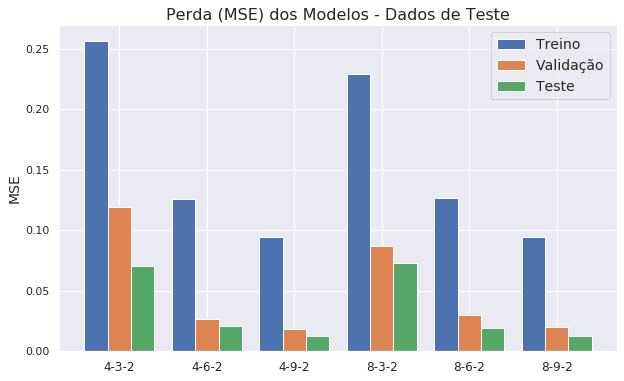

In [18]:
models4 = [model_432,model_462,model_492]
models8 = [model_832,model_862,model_892]
history_list = [history_432,history_462,history_492,history_832,history_862,history_892]

labels = ["4-3-2",'4-6-2','4-9-2',"8-3-2",'8-6-2','8-9-2']
fig,ax = plt.subplots(1,1,figsize=(10,6))

test_mse = []
train_mse = []
val_mse = []
for model in models4:
    test_mse.append(model.evaluate(xtest,ytest,verbose=0))
for model in models8:
    test_mse.append(model.evaluate(xtest2,ytest2,verbose=0))
for history in history_list:
    train_mse.append(np.mean(history.history['loss']))
    val_mse.append(np.mean(history.history['val_loss']))
wid = 0.8/3-0.0001
ax.set_title("Perda (MSE) dos Modelos - Dados de Teste",fontsize=16)
ax.set_ylabel("MSE",fontsize=14)
ax.bar(np.arange(0,6)-wid,train_mse,label="Treino",width = wid)
ax.bar(np.arange(0,6),val_mse,label='Validação',width = wid)
ax.bar(np.arange(0,6)+wid,test_mse,label = "Teste",width = wid)
ax.set_xticklabels(['0']+labels,fontsize=12)
ax.legend(loc='best',fontsize=14);
plt.savefig('../figs/NN_Models_MSE.jpg')


(0.012886094205450727, 0.012763977983615548)

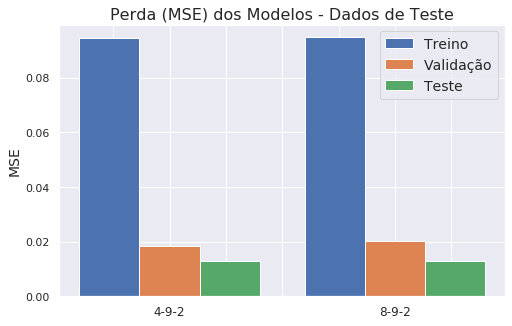

In [31]:

history_list = [history_492,history_892]

labels = ['4-9-2','8-9-2']
fig,ax = plt.subplots(1,1,figsize=(8,5))

test_mse = []
train_mse = []
val_mse = []

test_mse.append(model_492.evaluate(xtest,ytest,verbose=0))

test_mse.append(model_892.evaluate(xtest2,ytest2,verbose=0))
for history in history_list:
    train_mse.append(np.mean(history.history['loss']))
    val_mse.append(np.mean(history.history['val_loss']))
wid = 0.8/3-0.0001
ax.set_title("Perda (MSE) dos Modelos - Dados de Teste",fontsize=16)
ax.set_ylabel("MSE",fontsize=14)
ax.bar(np.arange(0,2)-wid,train_mse,label="Treino",width = wid)
ax.bar(np.arange(0,2),val_mse,label='Validação',width = wid)
ax.bar(np.arange(0,2)+wid,test_mse,label = "Teste",width = wid)
ax.set_xticklabels(['','','4-9-2','','','','8-9-2'],fontsize=12)
ax.legend(loc='best',fontsize=14);
plt.savefig('../figs/NN_Models_4vs8.jpg')
model_492.evaluate(xtest,ytest,verbose=0),model_892.evaluate(xtest2,ytest2,verbose=0)

Vemos que os modelos 4-9-2 e 8-9-2 performaram melhor em todos os conjuntos de dados. Vemos que 9 neurônios internos performam muito bem. Vamos trabalhar com esses modelos a partir daqui. Em especial, com o 8-9-2, que teve uma menor perda nos dados de teste; Ele utiliza uma maior quantidade de informações climáticas; esses dados climáticos à mais como entrada, apesar de serem médias mensais, possuem o caráter de localização geográfica imbutido, e podem prover informações sobre o comportamento futuro da trajetória de um furacão. Abaixo também podemos ver que a convergência dos dois modelos de 9 neurônios internos é parecida. 

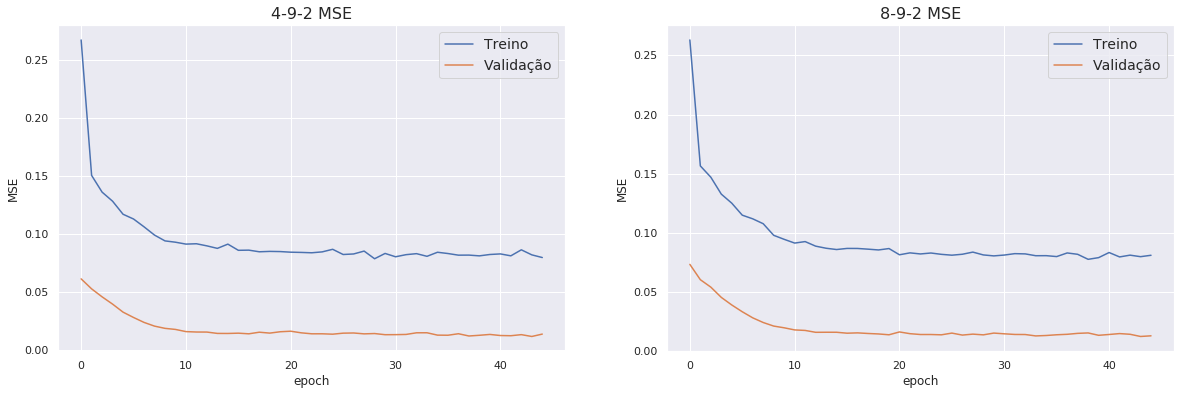

In [20]:
# Plotando MSE para Treino e Validação
fig, (ax,ax1) = plt.subplots(1,2, figsize=(20,6))

ax.plot(history_492.history['loss'])
ax.plot(history_492.history['val_loss'])
ax.set_title('4-9-2 MSE',fontsize=16)
ax.set_ylabel('MSE')
ax.set_xlabel('epoch')
ax.legend(['Treino', 'Validação'], fontsize=14,loc='best')
ax1.plot(history_892.history['loss'])
ax1.plot(history_892.history['val_loss'])
ax1.set_title('8-9-2 MSE',fontsize = 16)
ax1.set_ylabel('MSE')
ax1.set_xlabel('epoch')
ax1.legend(['Treino', 'Validação'], fontsize=14,loc='best');
plt.savefig('../figs/MSE-epoch.jpg')

R2 Latitude Teste - 0.987081477467329
R2 Longitude Teste - 0.9867822496295855
R2 Total Teste - 0.9869318635484573


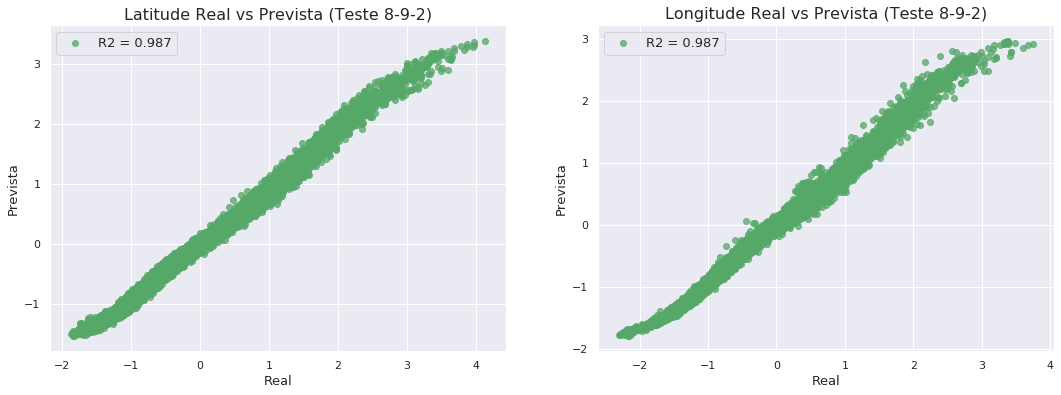

In [21]:
from sklearn.metrics import r2_score
ypred = model_892.predict(xtest2)

lat_r2 = r2_score(ytest2[:,0],ypred[:,0])
lon_r2 = r2_score(ytest2[:,1],ypred[:,1])
tot_r2 = r2_score(ytest2,ypred)

print(f"R2 Latitude Teste - {lat_r2}")
print(f"R2 Longitude Teste - {lon_r2}")
print(f"R2 Total Teste - {tot_r2}")

fig, (ax,ax1) = plt.subplots(1,2,figsize=(18,6))
ax.set_title("Latitude Real vs Prevista (Teste 8-9-2)",fontsize=16)
ax.set_xlabel("Real",fontsize = 13)
ax.set_ylabel("Prevista",fontsize = 13)
ax.scatter(ytest2[:,0],ypred[:,0],alpha = 0.75, color = 'g',label = f"R2 = {round(lat_r2,3)}")
ax.legend(loc='best', fontsize = 13)
ax1.set_title("Longitude Real vs Prevista (Teste 8-9-2)",fontsize=16)
ax1.set_xlabel("Real",fontsize = 13)
ax1.set_ylabel("Prevista",fontsize = 13)
ax1.scatter(ytest2[:,1],ypred[:,1],alpha = 0.75, color = 'g',label = f"R2 = {round(lon_r2,3)}")
ax1.legend(loc='best', fontsize = 13);
plt.savefig('../figs/lat_lon_teste.jpg')

Nos dados de teste, temos resultados muito bons! Abaixo vemos um esquema do modelo 8-9-2.

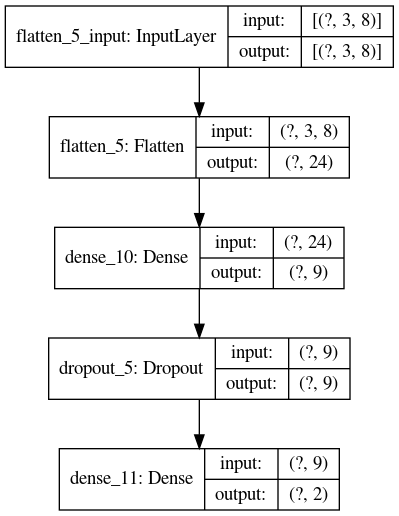

In [22]:
tf.keras.utils.plot_model(
    model_892,
    to_file='../figs/model_892.png', 
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)
# plt.savefig('figs/model892.jpg')

## Previsões

Vamos testar a previsão para algumas tempestades específicas do conjunto de testes.

In [23]:
splitted_data = split(data)
n = len(splitted_data)
test_storms = splitted_data[int(n*(0.9)):]
data_test = pd.concat(test_storms)
data_test.loc[:,'Hours'] = (data_test.loc[:,'Time_new']-pd.Timestamp(1951,1,1))/pd.Timedelta('1 hour')
data_test.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Latitude_c,Longitude_c,Duration,sst,rhum,wspd,slp,cldc,Time_new,Hours
20259,AL022011,BRET,2011-07-16,600,NaN,LO,30.7,-79.7,20,1014,...,30.7,-79.7,7,29.212346,81.503754,81.503754,1003.891696,4.721866,2011-07-16 06:00:00,530670.0
20260,AL022011,BRET,2011-07-16,1200,NaN,LO,30.3,-79.4,20,1014,...,30.3,-79.4,7,29.212489,81.512076,81.512076,1003.897948,4.720945,2011-07-16 12:00:00,530676.0
20261,AL022011,BRET,2011-07-16,1800,NaN,LO,29.8,-79.1,20,1014,...,29.8,-79.1,7,29.141944,82.018334,82.018334,1005.045524,4.940012,2011-07-16 18:00:00,530682.0
20262,AL022011,BRET,2011-07-17,0,NaN,LO,29.3,-78.8,20,1014,...,29.3,-78.8,7,28.998422,82.957671,82.957671,1005.403854,4.952418,2011-07-17 00:00:00,530688.0
20263,AL022011,BRET,2011-07-17,600,NaN,LO,28.8,-78.5,20,1014,...,28.8,-78.5,7,28.999376,82.953919,82.953919,1005.405851,4.950652,2011-07-17 06:00:00,530694.0


In [46]:
import warnings
warnings.simplefilter("ignore")
def predict_storm(ID):
    name = data_test[data_test.ID==ID].Name.iloc[0]
    year = data_test[data_test.ID==ID].Year.iloc[0]
    storm = data_test[data_test.ID==ID]
    storm.loc[:,cols2]=standard_scale(storm,cols2)
    st = storm.loc[:,cols2]
    st_pred = predict(st,model_892)
    st_plot = st.iloc[0:-4,:]
    
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    fig.suptitle(f"Furacão {name} - {year}", fontsize=16,y=1.08)
    ax[0].set_title("Latitude")
    ax[1].set_title("Longitude")
    print(r2_score(ir_plot.Latitude,ir_pred[:,0]))
    print(r2_score(ir_plot.Longitude,ir_pred[:,1]))
    ax[0].scatter(ir_plot.Hours,ir_plot.Latitude,label = 'Real')
    ax[0].scatter(ir_plot.Hours,ir_pred[:,0],label = 'Previsto')
    ax[1].scatter(ir_plot.Hours,ir_plot.Longitude,label = 'Real')
    ax[1].scatter(ir_plot.Hours,ir_pred[:,1],label = 'Previsto')
    ax[0].legend(loc='best')
    ax[1].legend(loc='best')
    plt.savefig(f"../figs/NN-{name}.jpg")

0.9161877823232963
0.8731283033906787


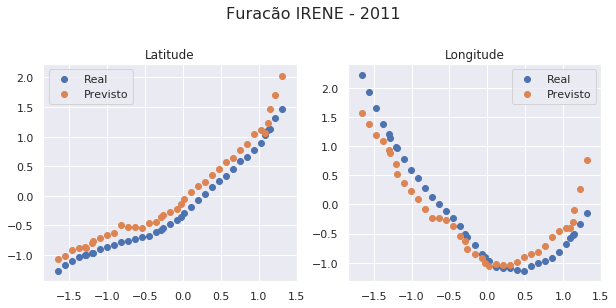

In [47]:
predict_storm('AL092011')

0.9161877823232963
0.8731283033906787


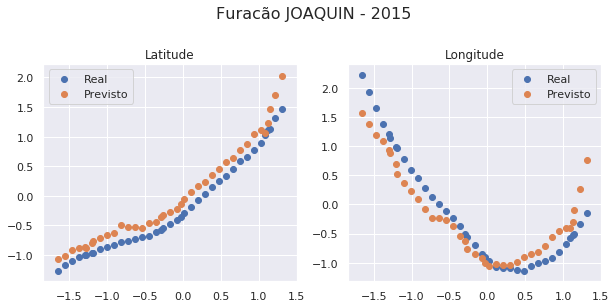

In [48]:
predict_storm('AL112015')

In [57]:
# data_test[(data_test.Duration>7)&(data_test.Name!="IRENE")&(data_test.Name!="JOAQUIN")].sort_values(by='Maximum Wind',ascending=0)

0.9161877823232963
0.8731283033906787


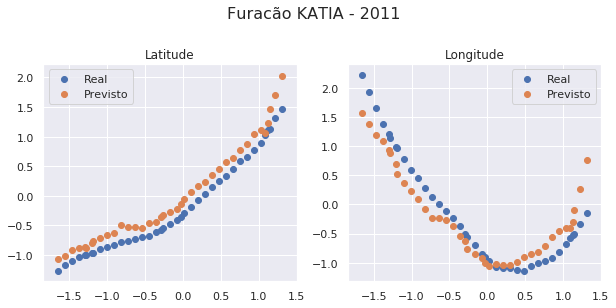

In [56]:
predict_storm('AL122011')